# Project 3: EDA and Preprocessing
---

Notebook Organisation:
1. Webscraping (SavingMoney & Investing)
2. **EDA and Preprocessing**
3. Model Tuning and Insights

## Content
---

- [Library](#Libraries)
- [Read CSV](#Read-CSV)
- [Initial EDA](#Initial-EDA)
- [Preprocessing](#Preprocessing)
- [EDA on Processed Data](#EDA-on-Processed-Data)
- [Merging Data](#Merging-the-Data-Frames-(Savings-&-Investing))
- [Observations](#Observations)

## Libraries
---

In [1]:
import requests
import time
import nltk
import pandas as pd
import regex as re
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import scipy.stats as stats
import warnings
from wordcloud import WordCloud, ImageColorGenerator
import string

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')
sns.set_style('ticks')
%matplotlib inline

## Read CSV
---

In [2]:
saving = pd.read_csv('data/saving_reddit_posts_selected.csv')
saving.shape

(689, 5)

In [3]:
investment = pd.read_csv('data/investment_reddit_posts_selected.csv')
investment.shape

(505, 5)

## Initial EDA
---

**EDA and Data Cleaning**

Prior to Data Cleaning, an intital EDA was conducted to spot the top words within the subreddit. <br>
As this was conducted prior to data cleaning, there are numerical values, website/url and words that have yet to be lemmatize. However, the initial EDA provided me insights on how the data cleaning should be done in order to avoid over cleaning of data. <br>

In [4]:
# instantiate a basic vectoriser with only settings for extracting bi- and tri-grams
cvec = CountVectorizer(stop_words = 'english', ngram_range = (2,3))

### Top 50 title content for each subreddit

Some of the top key words based on the title are saving, save for SavingMoney while investing seems to have a wide variety of words based on bi-gram and tri-grams. Words like saving, save, savings will be removed as stop words subsequently to increase its variance in the model.

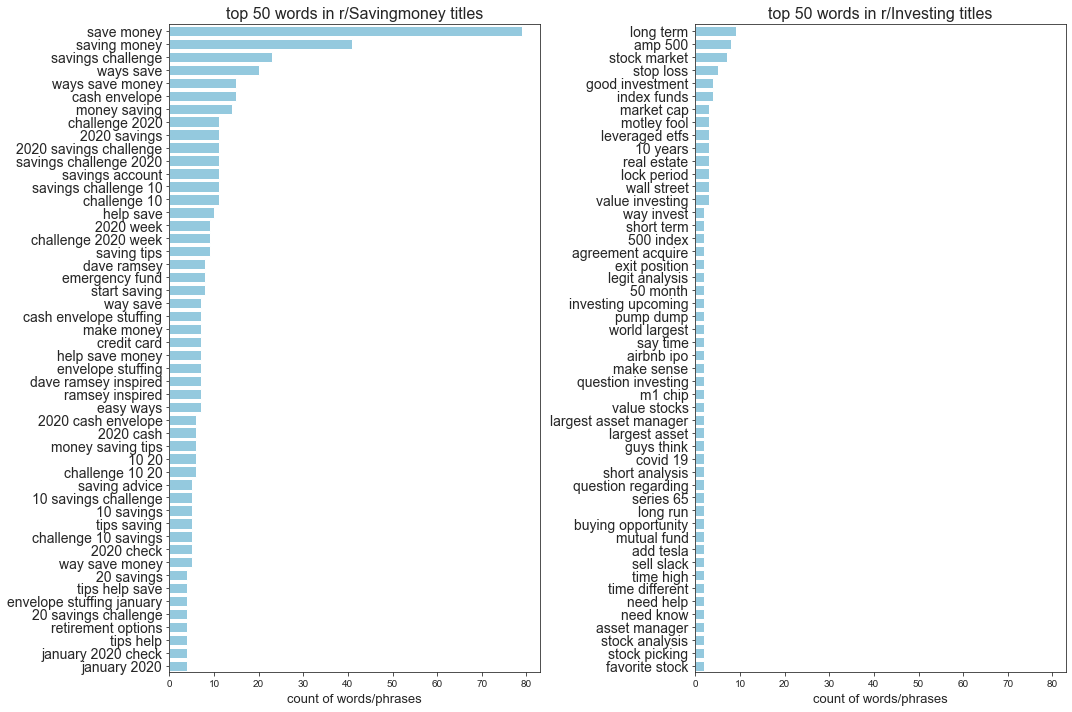

In [5]:
# r/SavingMoney - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_saveT = cvec.fit_transform(saving['title'])
vec_saveT = pd.DataFrame(vec_saveT.toarray(), columns = cvec.get_feature_names())
save_title_50 = vec_saveT.sum().sort_values(ascending=False).head(50)

# r/Investing - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_investT = cvec.fit_transform(investment['title'])
vec_investT = pd.DataFrame(vec_investT.toarray(), columns = cvec.get_feature_names())
invest_title_50 = vec_investT.sum().sort_values(ascending=False).head(50)

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=save_title_50.index.values, x = save_title_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in r/Savingmoney titles',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=invest_title_50.index.values, x = invest_title_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in r/Investing titles',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

### Top 50 body content of subreddit

Some of the top key words based on the title are html and ampx200b within both the post of the subreddit. Those word will be removed as stop words subsequently to increase its variance in the model.

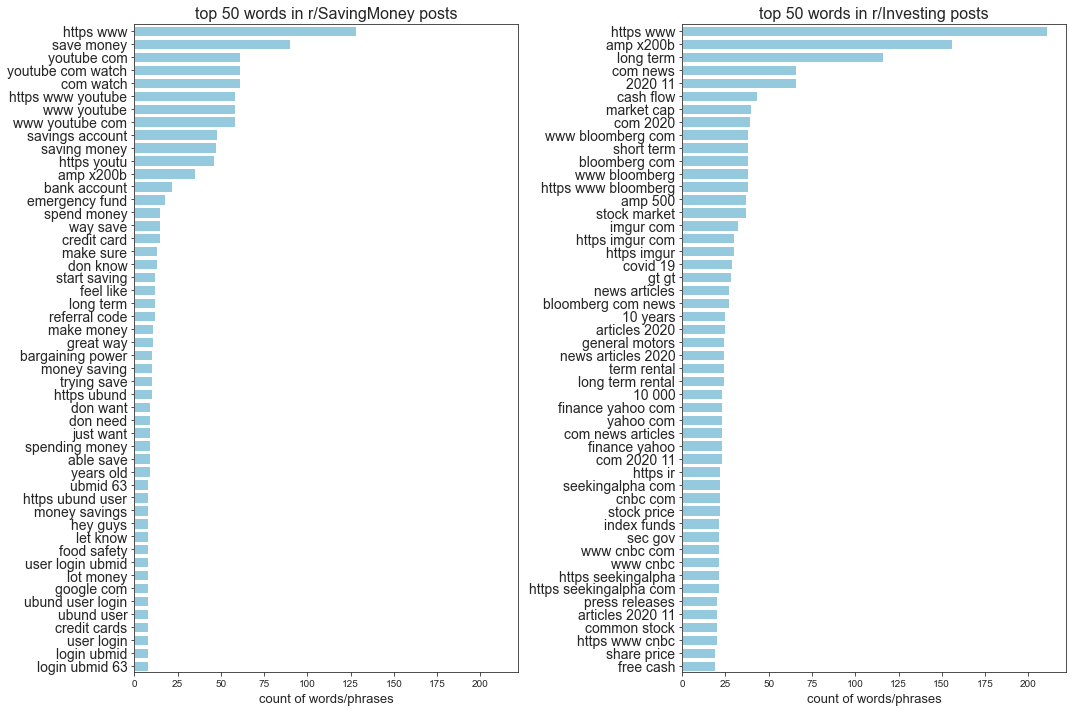

In [6]:
# preliminary filling of nan values for vectorising/plotting
investment['selftext'].fillna(value = 'notext', inplace=True)
saving['selftext'].fillna(value = 'notext', inplace=True)

# r/Savings - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_saveB = cvec.fit_transform(saving['selftext'])
vec_saveB = pd.DataFrame(vec_saveB.toarray(), columns = cvec.get_feature_names())
save_post_50 = vec_saveB.sum().sort_values(ascending=False).head(50)

# r/Investing - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_investB = cvec.fit_transform(investment['selftext'])
vec_investB = pd.DataFrame(vec_investB.toarray(), columns = cvec.get_feature_names())
invest_post_50 = vec_investB.sum().sort_values(ascending=False).head(50)

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=save_post_50.index.values, x = save_post_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in r/SavingMoney posts',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=invest_post_50.index.values, x = invest_post_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in r/Investing posts',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

### Moderator post within subreddit

Post from moderators within each subreddit are often advice or guideline.
The contents are not related to the topic itself but rather rules and regulations in maintaing the subreddit. These posts will be remove during preprocessing.

In [7]:
saving[saving['distinguished'] == 'moderator']

,subreddit,id,distinguished,title,selftext
0,SavingMoney,calpl0,moderator,Most Common Money Saving Tools: Do NOT Post Th...,In order to minimize the constant referral pos...


In [8]:
investment[investment['distinguished'] == 'moderator']

,subreddit,id,distinguished,title,selftext
1,investing,k4jq8t,moderator,Daily Advice Thread - All basic help or advice...,"If your question is ""I have $10,000, what do I..."


In [9]:
# number of moderator posts
print(saving.distinguished.value_counts())
print(investment.distinguished.value_counts())

moderator    1
Name: distinguished, dtype: int64
moderator    1
Name: distinguished, dtype: int64


For the posts within SavingMoney and Investing, most common word found was "amp x200b" (which essential means zero width space "&#x200B", this will be dealt with later) as many of the users were sharing websites on saving and investing. So we will proceed to search post content based on the subsequent most popular word.

In [10]:
saving[saving['selftext'].str.contains('save money')].head()

,subreddit,id,distinguished,title,selftext
0,SavingMoney,calpl0,moderator,Most Common Money Saving Tools: Do NOT Post Th...,In order to minimize the constant referral pos...
5,SavingMoney,k2dbu9,NaN,An uncommon way to actually save money: improv...,"I'm always trying to think smart, and while ev..."
7,SavingMoney,k109nz,NaN,Saving on Software,"As the holiday season comes closer, that nee..."
9,SavingMoney,jzteut,NaN,I save thousands on groceries!!,I break down how you can easily save money on ...
12,SavingMoney,jxvoop,NaN,How to Save Money to Have More Money to Spend,"I love saving money. Why? I love saving money,..."


In [11]:
investment[investment['selftext'].str.contains('long term')].head()

,subreddit,id,distinguished,title,selftext
28,investing,k3unr7,NaN,TSLA: Get ready to cash out from the largest o...,"Ok, so TSLA will be included in S&amp;P 500 in..."
57,investing,k44tfp,NaN,$DMYD : Own the Big Data Provider that Powers ...,\n\n[UK's Genius Sports bets on NY-listed SPA...
73,investing,k41gwg,NaN,"Deep Dive #1 (Part 1 of 2) – DraftKings, bring...",Hi everyone - \n\nI have been very passionate ...
78,investing,k440wk,NaN,A case for holding...,"The kids at r/wallstreetbets didn’t like this,..."
89,investing,k4bykn,NaN,Question on tax for stocks,"Hello! As the header states, I had a quick que..."


## Preprocessing
---

In [12]:
def preprocess(df_posts):
    
    # Removing moderator post and dropping distiguishsed column
    
    df_posts = df_posts[df_posts.distinguished != 'moderator']
    df_posts.drop(columns = 'distinguished', inplace = True)

    # Filling in null values
    
    df_posts.fillna(value = 'notext', inplace=True)

    #Obtaining length of title and text
    
    df = df_posts
    df['title_len'] = [len(x) for x in df['title'].str.split(' ')]
    df['text_len'] = [len(x) for x in df['selftext'].str.split(' ')]

    # removing html within post
    
    regex_html = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
    df['title'].replace(regex=True,inplace=True, to_replace=regex_html,value=r'')
    df['selftext'].replace(regex=True,inplace=True, to_replace=regex_html,value=r'')
    
    return df

In [13]:
saving = preprocess(saving)
investment = preprocess(investment)

In [14]:
saving.head()

,subreddit,id,title,selftext,title_len,text_len
1,SavingMoney,jth9il,"Heads up: If you post a Yotta referral, I'm ju...",I just cleared out the mod queue and HOLY CRAP...,17,16
2,SavingMoney,k4tihv,Everything is Negotiable,Throughout my time working at a New York based...,3,925
3,SavingMoney,k51oue,Best currency and saving bank account? (Advice...,"I'm 20 and I never saved money for ""big projec...",11,119
4,SavingMoney,k3ejpc,Looking to switch my bank,Which bank is the most reasonable in terms of ...,5,15
5,SavingMoney,k2dbu9,An uncommon way to actually save money: improv...,"I'm always trying to think smart, and while ev...",11,221


In [15]:
investment.head()

,subreddit,id,title,selftext,title_len,text_len
0,investing,cyee69,Formal posting guidelines for political topics...,"Alright everyone, it looks like we had pretty ...",20,1349
2,investing,k4ue9o,Salesforce Signs Definitive Agreement to Acqui...,"&gt; \n\n&gt; Salesforce (NYSE: CRM), the glob...",7,142
3,investing,k4j98w,Canadian electric truck and bus manufacturer t...,\n\nCanadian electric truck and bus manufactur...,15,362
4,investing,k4w85m,Airbnb (ABNB) IPO S1 Filing Summary,Hopefully this quick summary video will be hel...,6,122
5,investing,k4t0hq,Blackberry announces agreement with Amazon,Been following BB for a while since they had s...,5,1028


In [16]:
#remove url and digits
def review_to_words(raw_review):
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review)
    letters_oneline = re.sub('([\r\n]+)',' ', letters_only) 
    letters = re.sub('([ ]{2,})',' ',letters_oneline)
    
    # 3. Convert to lower case, split into individual words.
    words = letters.lower().split()
    
    # 4. Remove stopwords.
    stops = set(stopwords.words('english'))
    stops.update(['saved', 'save', 'saving', 'savings', 'invest', 'investment', 'investing', 'notext', 'thank'])
    meaningful_words = [w for w in words if w not in stops]
    
    # 5.Instantiate lemmatizer. (Same as above.)
    lemmatizer = WordNetLemmatizer()
    
    # 6.Lemmatize tokens.
    tokens_lem = [lemmatizer.lemmatize(word) for word in meaningful_words]
    
    # 7. Join the words back into one string separated by space, and return the result.
    return(" ".join(tokens_lem))

In [17]:
saving['title_cleaned'] = saving['title'].map(review_to_words)
saving['selftext_cleaned'] = saving['selftext'].map(review_to_words)

In [18]:
saving[['title', 'title_cleaned']].head()

,title,title_cleaned
1,"Heads up: If you post a Yotta referral, I'm ju...",head post yotta referral straight permabanning...
2,Everything is Negotiable,everything negotiable
3,Best currency and saving bank account? (Advice...,best currency bank account advice begginer please
4,Looking to switch my bank,looking switch bank
5,An uncommon way to actually save money: improv...,uncommon way actually money improve credit score


In [19]:
saving[['selftext', 'selftext_cleaned']].head()

,selftext,selftext_cleaned
1,I just cleared out the mod queue and HOLY CRAP...,cleared mod queue holy crap jammed full spammer
2,Throughout my time working at a New York based...,throughout time working new york based private...
3,"I'm 20 and I never saved money for ""big projec...",never money big project time spain currently l...
4,Which bank is the most reasonable in terms of ...,bank reasonable term monthly payout fee benefi...
5,"I'm always trying to think smart, and while ev...",always trying think smart everyone going crazy...


In [20]:
investment['title_cleaned'] = investment['title'].map(review_to_words)
investment['selftext_cleaned'] = investment['selftext'].map(review_to_words)

In [21]:
investment[['title', 'title_cleaned']].head()

,title,title_cleaned
0,Formal posting guidelines for political topics...,formal posting guideline political topic const...
2,Salesforce Signs Definitive Agreement to Acqui...,salesforce sign definitive agreement acquire s...
3,Canadian electric truck and bus manufacturer t...,canadian electric truck bus manufacturer ipo n...
4,Airbnb (ABNB) IPO S1 Filing Summary,airbnb abnb ipo filing summary
5,Blackberry announces agreement with Amazon,blackberry announces agreement amazon


In [22]:
investment[['selftext', 'selftext_cleaned']].head()

,selftext,selftext_cleaned
0,"Alright everyone, it looks like we had pretty ...",alright everyone look like pretty broad suppor...
2,"&gt; \n\n&gt; Salesforce (NYSE: CRM), the glob...",gt gt salesforce nyse crm global leader crm sl...
3,\n\nCanadian electric truck and bus manufactur...,canadian electric truck bus manufacturer lion ...
4,Hopefully this quick summary video will be hel...,hopefully quick summary video helpful everyone...
5,Been following BB for a while since they had s...,following bb since project going amazon micros...


## EDA on Processed Data
---

In [23]:
saving.describe().T

,count,mean,std,min,25%,50%,75%,max
title_len,688.0,9.844477,8.491314,1.0,5.0,8.0,11.00,61.0
text_len,688.0,60.552326,127.084106,1.0,1.0,12.5,70.25,1184.0


In [24]:
investment.describe().T

,count,mean,std,min,25%,50%,75%,max
title_len,504.0,9.279762,5.399277,1.0,6.0,8.0,12.0,39.0
text_len,504.0,190.837302,294.669909,8.0,65.0,102.0,173.0,2684.0


### EDA - Boxplot of Title and Post

The length of title and post from shows an interesting pattern for both subreddit. 

For r/SavingMoney, the title generally spans around 5 - 15 words with the exception of going close to 60 while some of the post has no useful content. This may indicate that title holds more information as compared to the post itself.For r/investing, the title and post are general balanced but there are exceptions of a long body within the post. 

Comparing both subreddit, SavingMoney generally has longer title while the post of Investing are longer as compared to other.

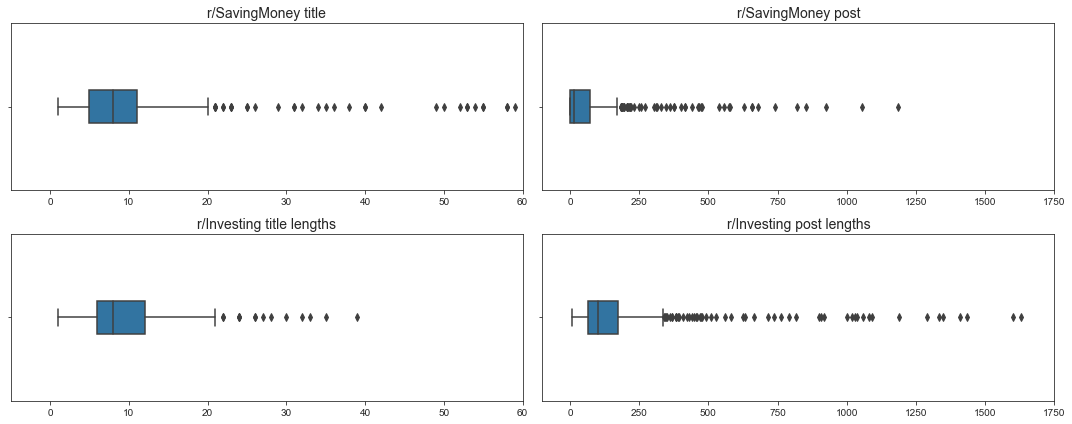

In [25]:
# plot distributions with same x axis range for each category
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 6))

sns.boxplot(saving['title_len'], ax = ax[0][0], width = 0.2)
ax[0][0].set_xlabel('')
ax[0][0].set_xlim(-5,60)
ax[0][0].set_title('r/SavingMoney title', fontsize=14)
sns.boxplot(saving['text_len'], ax = ax[0][1], width = 0.2)
ax[0][1].set_xlabel('')
ax[0][1].set_xlim(-100,1750)
ax[0][1].set_title('r/SavingMoney post', fontsize=14)


sns.boxplot(investment['title_len'], ax = ax[1][0], width = 0.2)
ax[1][0].set_xlabel('')
ax[1][0].set_xlim(-5,60)
ax[1][0].set_title('r/Investing title lengths', fontsize=14)
sns.boxplot(investment['text_len'], ax = ax[1][1], width = 0.2)
ax[1][1].set_xlabel('')
ax[1][1].set_xlim(-100,1750)
ax[1][1].set_title('r/Investing post lengths', fontsize=14)

plt.tight_layout();

### EDA - Histogram of Title and Post

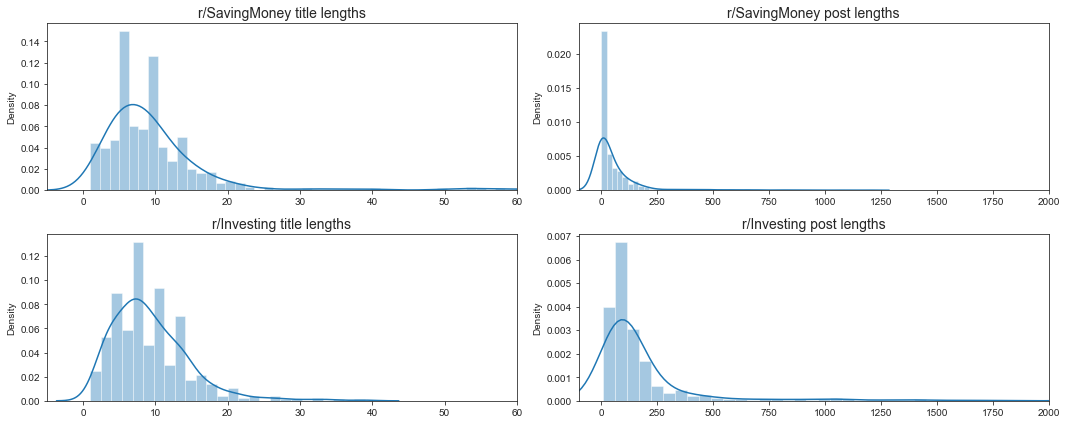

In [26]:
# plot distributions with same x axis range for each category
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 6))

sns.distplot(saving['title_len'], ax = ax[0][0])
ax[0][0].set_xlabel('')
ax[0][0].set_xlim(-5,60)
ax[0][0].set_title('r/SavingMoney title lengths', fontsize=14)
sns.distplot(saving['text_len'], ax = ax[0][1])
ax[0][1].set_xlabel('')
ax[0][1].set_xlim(-100,2000)
ax[0][1].set_title('r/SavingMoney post lengths', fontsize=14)

sns.distplot(investment['title_len'], ax = ax[1][0])
ax[1][0].set_xlabel('')
ax[1][0].set_xlim(-5,60)
ax[1][0].set_title('r/Investing title lengths', fontsize=14)
sns.distplot(investment['text_len'], ax = ax[1][1])
ax[1][1].set_xlabel('')
ax[1][1].set_xlim(-100,2000)
ax[1][1].set_title('r/Investing post lengths', fontsize=14)

plt.tight_layout()

### EDA - Barplot for Title (Top 50)

After processing, the title seems to be cleaner without common words like saving or investing. With emphasis for words like challenge which is one of the main term within r/SavingMoney as they use challenge to install a form of discipline for saving money. On the other hand, the investing focuses on the stock market looking into funds and stocks.

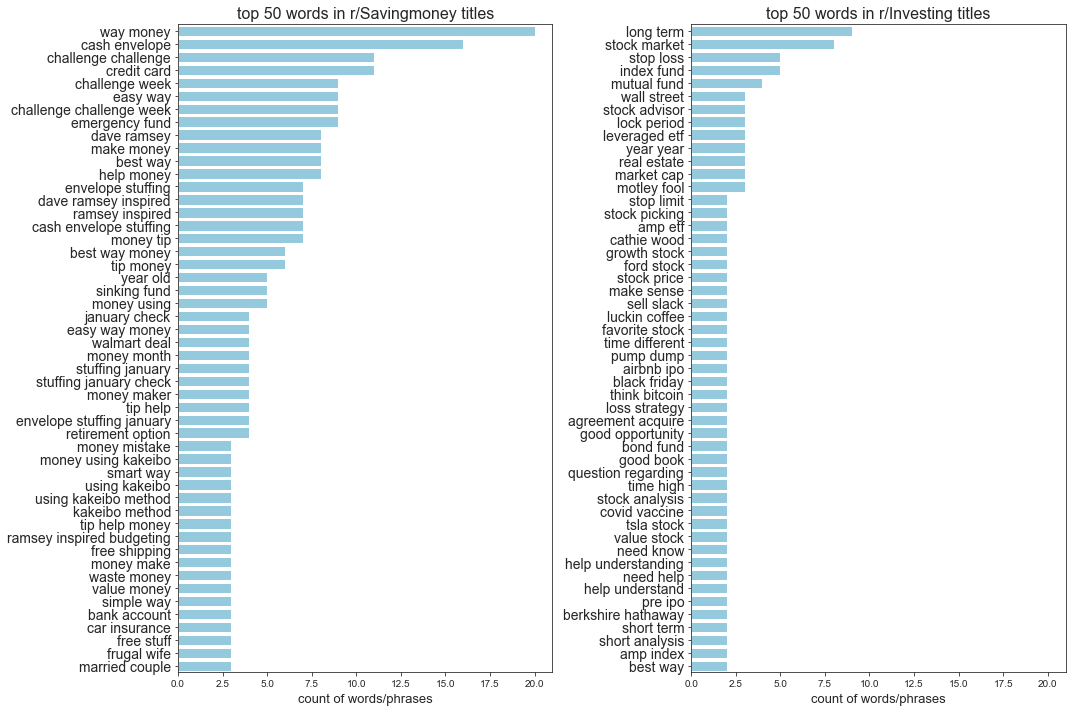

In [27]:
# r/SavingMoney - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_saveT = cvec.fit_transform(saving['title_cleaned'])
vec_saveT = pd.DataFrame(vec_saveT.toarray(), columns = cvec.get_feature_names())
save_title_50 = vec_saveT.sum().sort_values(ascending=False).head(50)

# r/Investing - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_investT = cvec.fit_transform(investment['title_cleaned'])
vec_investT = pd.DataFrame(vec_investT.toarray(), columns = cvec.get_feature_names())
invest_title_50 = vec_investT.sum().sort_values(ascending=False).head(50)

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=save_title_50.index.values, x = save_title_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in r/Savingmoney titles',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=invest_title_50.index.values, x = invest_title_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in r/Investing titles',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

### EDA - WordCloud for Title (Top 50)

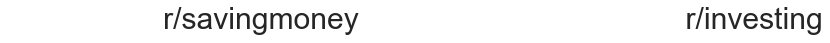

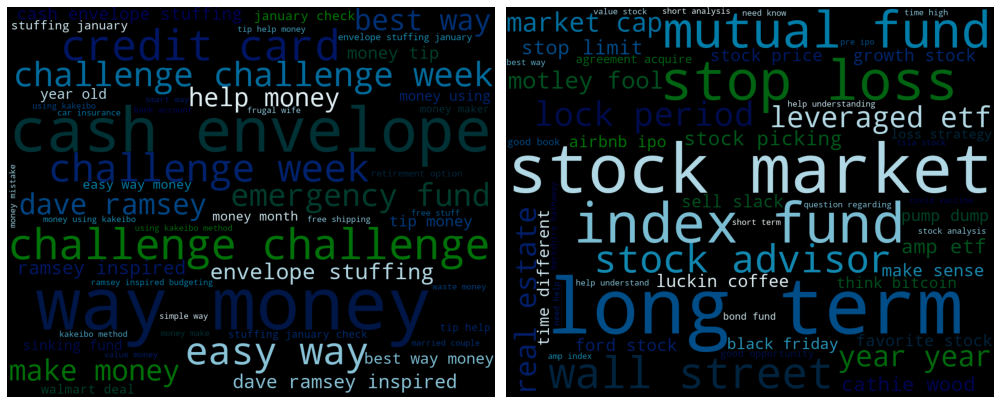

In [46]:
# set up WordCloud
wc_save = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(save_title_50) 

wc_invest = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(invest_title_50) 

plt.figure(figsize=(8, 0.3))
plt.text(x = 0.35,                              
         y = 0.9,                             
         s = 'r/savingmoney                                       r/investing', 
         ha = 'left',                        
         va = 'center',                       
         size = 30)                         
plt.axis('off')

# plot the WordCloud image 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].imshow(wc_save)
ax[0].axis('off')
ax[1].imshow(wc_invest)
ax[1].axis('off')
plt.tight_layout()

### EDA - Venn Diagram for Title (Top 50)

The Venn DIagram is shows the potential among the top 50 words, the commonality of subreddit based on title. As among the top 50 words, the only common term is one. This indicates that the subreddit are distinct based on their titles.

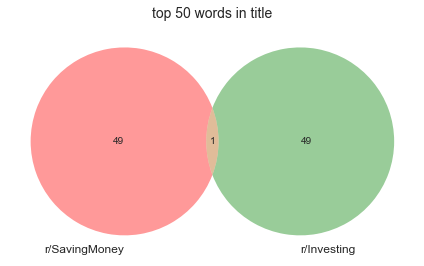

In [29]:
venn2([set(save_title_50.index), set(invest_title_50.index)], set_labels = ('r/SavingMoney','r/Investing'))
plt.title('top 50 words in title', fontsize=14)
plt.tight_layout()

### EDA - Barplot for Post (Top 50)

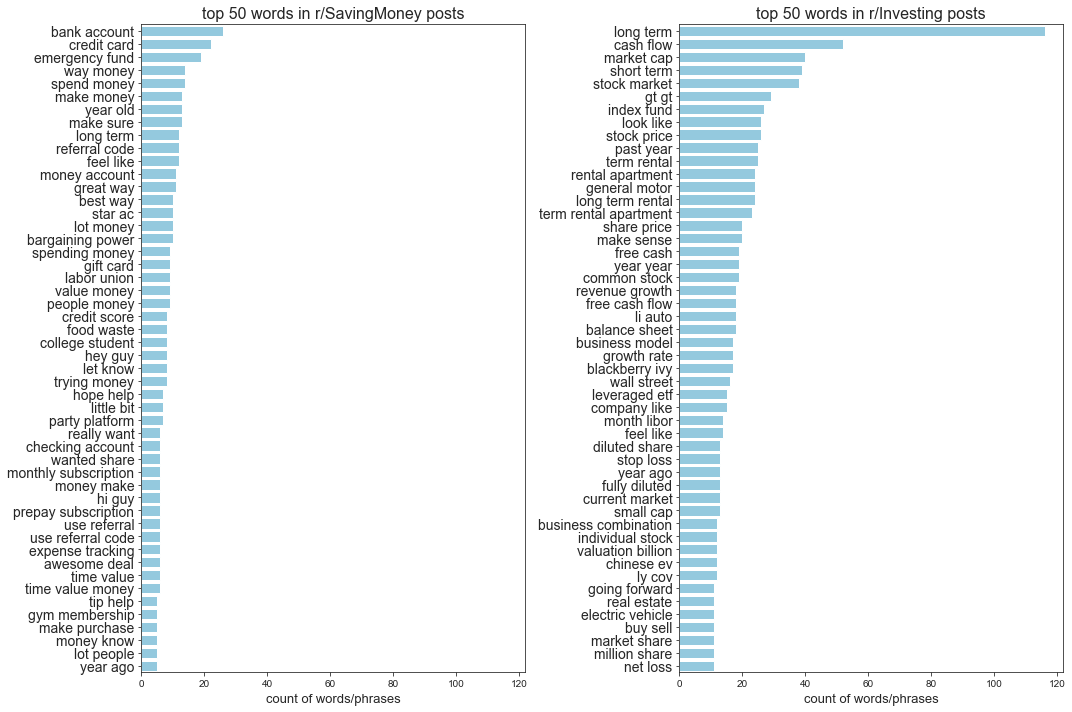

In [30]:
# preliminary filling of nan values for vectorising/plotting
investment['selftext'].fillna(value = 'notexthere', inplace=True)
saving['selftext'].fillna(value = 'notexthere', inplace=True)

# r/Savings - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_saveB = cvec.fit_transform(saving['selftext_cleaned'])
vec_saveB = pd.DataFrame(vec_saveB.toarray(), columns = cvec.get_feature_names())
save_post_50 = vec_saveB.sum().sort_values(ascending=False).head(50)

# r/Investing - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_investB = cvec.fit_transform(investment['selftext_cleaned'])
vec_investB = pd.DataFrame(vec_investB.toarray(), columns = cvec.get_feature_names())
invest_post_50 = vec_investB.sum().sort_values(ascending=False).head(50)

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=save_post_50.index.values, x = save_post_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in r/SavingMoney posts',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=invest_post_50.index.values, x = invest_post_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in r/Investing posts',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

### EDA - WordCloud for Post (Top 50)

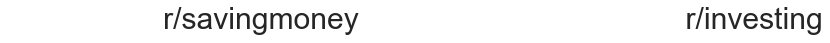

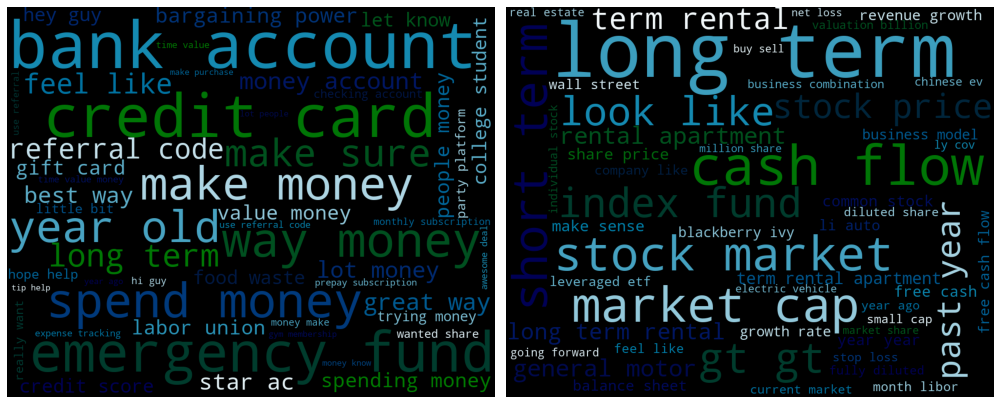

In [51]:
# set up WordCloud
wc_save = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(save_post_50) 

wc_invest = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(invest_post_50) 

plt.figure(figsize=(8, 0.3))
plt.text(x = 0.35,                              
         y = 0.9,                             
         s = 'r/savingmoney                                       r/investing', 
         ha = 'left',                        
         va = 'center',                       
         size = 30)                         
plt.axis('off')

# plot the WordCloud image 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].imshow(wc_save)
ax[0].axis('off')
ax[1].imshow(wc_invest)
ax[1].axis('off')
plt.tight_layout()

### EDA - Venn Diagram for Post (Top 50)

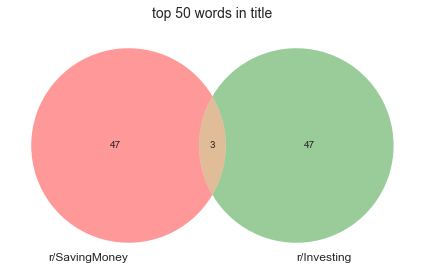

In [49]:
venn2([set(save_post_50.index), set(invest_post_50.index)], set_labels = ('r/SavingMoney','r/Investing'))
plt.title('top 50 words in title', fontsize=14)
plt.tight_layout()

## Merging the Data Frames (Savings & Investing)
---

In [33]:
combine = saving.append(investment, ignore_index=True)

In [34]:
combine['subreddit'] = combine['subreddit'].map({'SavingMoney' : 1, 'investing': 0})

In [35]:
dup = combine[(combine.duplicated(subset = ['title']) == True) & (combine.duplicated(subset = ['selftext']) == True)]\
['title'].value_counts()

print(len(dup))

0


In [36]:
combine['subreddit'].value_counts(normalize = True)

1    0.577181
0    0.422819
Name: subreddit, dtype: float64

In [37]:
combine.head()

,subreddit,id,title,selftext,title_len,text_len,title_cleaned,selftext_cleaned
0,1,jth9il,"Heads up: If you post a Yotta referral, I'm ju...",I just cleared out the mod queue and HOLY CRAP...,17,16,head post yotta referral straight permabanning...,cleared mod queue holy crap jammed full spammer
1,1,k4tihv,Everything is Negotiable,Throughout my time working at a New York based...,3,925,everything negotiable,throughout time working new york based private...
2,1,k51oue,Best currency and saving bank account? (Advice...,"I'm 20 and I never saved money for ""big projec...",11,119,best currency bank account advice begginer please,never money big project time spain currently l...
3,1,k3ejpc,Looking to switch my bank,Which bank is the most reasonable in terms of ...,5,15,looking switch bank,bank reasonable term monthly payout fee benefi...
4,1,k2dbu9,An uncommon way to actually save money: improv...,"I'm always trying to think smart, and while ev...",11,221,uncommon way actually money improve credit score,always trying think smart everyone going crazy...


In [38]:
combine.tail()

,subreddit,id,title,selftext,title_len,text_len,title_cleaned,selftext_cleaned
1187,0,jx3xfm,Full Bull?,I've been hearing alot of debate about whether...,2,62,full bull,hearing alot debate whether full bull financia...
1188,0,jw0s0v,"Berkshire Hathaways 13-F Filings, Slashes Well...","Didn't see anyone post about this, but here's ...",16,56,berkshire hathaway f filing slash well fargo h...,see anyone post picture notable movement portf...
1189,0,jwep3u,The AMC question,How are people feeling about AMC...? On the on...,3,103,amc question,people feeling amc one hand news vaccine could...
1190,0,jwomef,Options for All Cap exposure to Value Stocks,Is there an ETF that tracks value stocks in al...,8,49,option cap exposure value stock,etf track value stock capitalization far found...
1191,0,jwsn3x,Is anyone else eyeing Sumo Logic (SUMO)?,Cloud companies have gotten a lot of hype this...,7,74,anyone else eyeing sumo logic sumo,cloud company gotten lot hype year one seems f...


In [44]:
combine.to_csv('data/combine_reddit_posts.csv',index=False)

## Observations
---

Based on the EDA, the subreddits are quite distinct among each other for the title while post have a slightly higher commonality percentage but it is generally still considered low (with only 3 out of 50). The Barplot also shows the top bi-gram and tri-gram for each subreddit in title and post. While one emphasis is on challenge and plan, the other focuses on stock market and investment websites(montley fool). <br>
